In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.constants as cnt
from scipy.optimize import curve_fit

In [3]:
folder_path1 = "data/Aufspaltung2_Linie/1Peaks"
folder_path2 = "data/Aufspaltung2_Linie/2Peaks"
files1 = [f for f in os.listdir(folder_path1) if f.endswith('.dat')]
files2 = [f for f in os.listdir(folder_path2) if f.endswith('.dat')]

data1 = {}
data2 = {}

for file in files1:
    file_path = os.path.join(folder_path1, file)
    file_data = np.loadtxt(file_path)
    data1[file.replace('.dat', '').replace('_', '.')] = file_data

for file in files2:
    file_path = os.path.join(folder_path2, file)
    file_data = np.loadtxt(file_path)
    data2[file.replace('.dat', '').replace('_', '.')] = file_data

[(1300.0, 1600.0)]

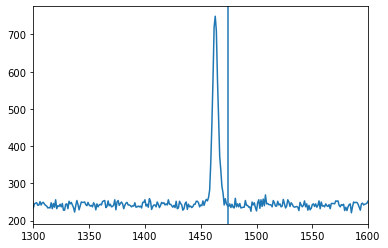

In [4]:
fig, ax = plt.subplots()
sigma = data1['0'][:,1]
pi = data2['0'][:,1]
pixels = data2['0'][:,0]
l,r = 1300, 1600
#ax.plot(data1['5.76'][:, 0], pi)
ax.plot(data1['5.76'][:, 0], sigma)

central_peak = pixels[l:r][np.argmax(pi[l:r])]
ax.axvline(central_peak)
ax.set(xlim=[l, r])
#ax.plot(data2['0'][:, 0], data2['0'][:,1])

In [38]:
slope = 0.0010609668109668772
centralwavelength = 585.249

I_to_B = {"0": 0, "0.81": 5, "1.57": 10, "2.28": 15, "3.17": 20, "5.76" : 25}
def steps2lambda(steps):
    return (steps * slope - central_peak*slope)

def gauss_function(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def centered_gauss(x, a, sigma):
    return gauss_function(x, a, 0, sigma)

def two_gauss_function(x, a, width, sigma):
    return gauss_function(x, a, -width, sigma) + gauss_function(x, a, width, sigma)

def gauss_area(a, sigma):
    return a * np.sqrt( 2 * np.pi * np.abs(sigma))

C:\Users\christiansenh\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


B =0.0T Area1 4446926.20371676, Area2 83.68106699217049
B =0.5T Area1 133.3666389666188, Area2 91.17886263313542
B =1.0T Area1 149.68527711594646, Area2 87.36698067827132
B =1.5T Area1 200.62765907742173, Area2 102.89738453650777
B =2.0T Area1 97.78533651515058, Area2 53.04282562304134
B =2.5T Area1 83.28315245530442, Area2 48.51733375696369


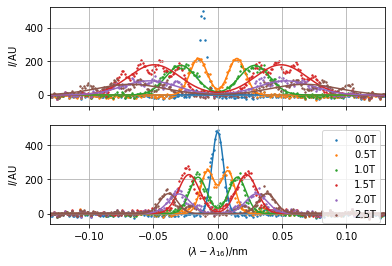

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
width = .13
ax1.grid()
ax2.grid()
background = 250
offsets = [0, 0.02, 0.02, 0.028, 0.032,0.042]
offsets2 = [0, 0.01, 0.02, 0.02, 0.032,0.042]
offsets_measured1 = []
offsets_measured2 = []
magnetic_fields = []
for i, B in enumerate(data1):
    if True:#i in [1,3]:
        lambdas = steps2lambda(data1[B][:, 0])
        inten1 = data1[B][:, 1] - background
        inten2 = data2[B][:, 1] - background
        left, right = (np.argmin(np.abs(lambdas + width)), np.argmin(np.abs(lambdas - width)))
        left, right = (np.argmin(lambdas), np.argmax(lambdas))


        p0 = [inten1.max(), 0.1]
        coeff1, p_cov1  = curve_fit(two_gauss_function, lambdas[left:right], inten1[left:right], p0=[inten1.max() / 5, offsets[i], 1e-3], maxfev=100000)
        coeff2, p_cov2  = curve_fit(two_gauss_function, lambdas[left:right], inten2[left:right], p0=[inten2.max() / 5, offsets2[i], 1e-3], maxfev=100000)

        print(f'B ={I_to_B[B] / 10}T Area1 {2* gauss_area(coeff1[0], coeff1[1])}, Area2 {2 * gauss_area(coeff2[0], coeff2[2])}')

        offsets_measured1.append(coeff1[1])
        offsets_measured2.append(coeff2[1])
        magnetic_fields.append(I_to_B[B]  / 10)

        lambdas_plot = np.linspace(min(lambdas), max(lambdas), 10000)
        ax1.scatter(lambdas, inten1, 2, label=f'{I_to_B[B]/10}T')
        ax1.plot(lambdas_plot, two_gauss_function(lambdas_plot, *coeff1))

        ax2.scatter(lambdas, inten2, 2,  label=f'{I_to_B[B]/10}T')
        ax2.plot(lambdas_plot, two_gauss_function(lambdas_plot, *coeff2))
ax1.set(ylabel="$I / \\mathrm{AU}$")
ax2.set(xlim=[-width, width], xlabel='$ (\\lambda - \\lambda_{16}) / \\mathrm{nm}$', ylabel="$I / \\mathrm{AU}$")
ax2.legend(loc=1)
fig.savefig('out/zeeman_splitting_strange')

e/m_e = 2.976e+11


-69.21538438400704

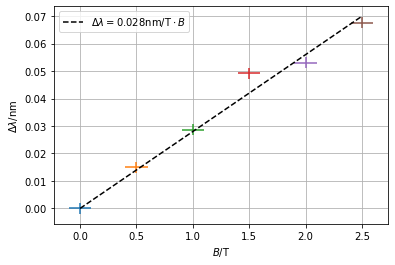

In [44]:
fig2, ax3 = plt.subplots()
offsets_measured1[0] = 0

x_error = np.full(len(magnetic_fields), 0.1)
y_error = np.full(len(magnetic_fields), 0.002)
ax3.errorbar(magnetic_fields, offsets_measured1, xerr=x_error, yerr=y_error, linestyle='none', ecolor=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
def lin_func(x, a):
    return x*a

coeff3, _ = curve_fit(lin_func, magnetic_fields, offsets_measured1)
bs = np.linspace(min(magnetic_fields), max(magnetic_fields), 100)
ax3.plot(bs, lin_func(bs, *coeff3), 'k--', label=f"$\\Delta \\lambda = {coeff3[0]:.3}\\mathrm{{nm}} / \\mathrm{{T}} \\cdot B$")
ax3.set(xlabel="$B / \\mathrm{T}$", ylabel="$\\Delta \lambda/ \\mathrm{nm}$")
ax3.grid()
ax3.legend()
fig2.savefig('out/e_m_lin_reg1')
e_m = (4 * np.pi * cnt.c) / ((centralwavelength* 1e-9)**2 * 1.034) * coeff3[0]*1e-9
print(f"e/m_e = {e_m:.3e}")
e_m_theo = cnt.e / cnt.m_e
(e_m_theo - e_m )/ e_m_theo * 100

e/m_e = 1.610e+11


8.468553693138151

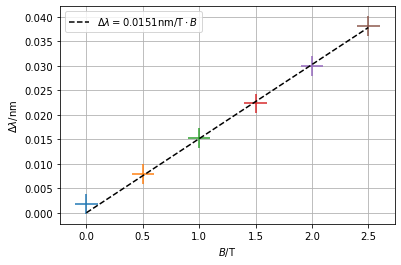

In [46]:
fig3, ax4 = plt.subplots()
offsets_measured1[0] = 0
#ax4.scatter(magnetic_fields, offsets_measured2, marker='x', c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
ax4.errorbar(magnetic_fields, offsets_measured2, xerr=x_error, yerr=y_error, linestyle='none', ecolor=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
def lin_func(x, a):
    return x*a

coeff3, _ = curve_fit(lin_func, magnetic_fields, offsets_measured2)
bs = np.linspace(min(magnetic_fields), max(magnetic_fields), 100)
ax4.plot(bs, lin_func(bs, *coeff3), 'k--', label=f"$\\Delta \\lambda = {coeff3[0]:.3}\\mathrm{{nm}} / \\mathrm{{T}} \\cdot B$")
ax4.set(xlabel="$B / \\mathrm{T}$", ylabel="$\\Delta \lambda/ \\mathrm{nm}$")
ax4.grid()
ax4.legend()
fig3.savefig('out/e_m_lin_reg2')
e_m = (4 * np.pi * cnt.c) / ((centralwavelength* 1e-9)**2 * 1.034) * coeff3[0]*1e-9
print(f"e/m_e = {e_m:.3e}")
e_m_theo = cnt.e / cnt.m_e
(e_m_theo - e_m )/ e_m_theo * 100